In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

CASE=1
if CASE==0: dname="DATA"
if CASE==1: 
    dname="DATA_b"
    A=4
if CASE==2:
    A=6
    dname="DATA_c"

fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])//A

SPINS = True
#SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0
    

# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 2
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
#print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

In [2]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()

[0, 0, 0, 0, 0]
[1, 1]


In [3]:
def rmsprop(data, model, s, beta, eps, l_rate_m):
    
    g = data - model
    s1 = beta*s + (1-beta)*g**2      
    d = l_rate_m * g/(np.sqrt(s1+eps))
      
    return s1, d

def adam(data, model, m, s, t, beta, eps, l_rate_m):
    
    g = data - model
    m0 = beta*m + (1-beta)*g
    s0 = beta*s + (1-beta)*g**2
    
    m1 = 1/(1-beta**(t+1))*m0
    s1 = 1/(1-beta**(t+1))*s0
    d = l_rate_m * m1/(np.sqrt(s1+eps))
      
    return m0, s0, d

In [4]:
def one_hot_negative(v_in,wei,bias,DE,info=False):
    #print(np.dot(v_in, wei), v_in, wei, bias)
    act = np.dot(v_in, wei) + bias
    #n = np.shape(act)
    #v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out = np.full((L*A,), vmin, dtype=int) # a list on -1's or 0's
    p = np.random.random(L)
    for i in range(L):
        probs = np.cumsum([1. / (1. + exp(-DE*(2**(j+1))*act[i])) for j in range(A)])
        #print(probs/probs[-1])
        probs/=probs[-1]
        for j in range(A):
            if p[i]<probs[j]:
                v_out[(i+1)*A-j-1]=1
                break
        
    #v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',probs)
        print('output=',v_out)
    
    return v_out

def one_hot_positive(v_in,wei,bias,DE,info=False):
    units=[v_in[i*A:(i+1)*A] for i in range(L)]
    #print(units)
    for i in range(L):
        v=units[i]
        u=0
        for j in range(A):
            u+=v[j]*2**(A-j-1)
        units[i]=u
    
    act = np.dot(units, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out


----------- epoch = 0   k= 499   m= 500
----------- epoch = 1   k= 499   m= 500


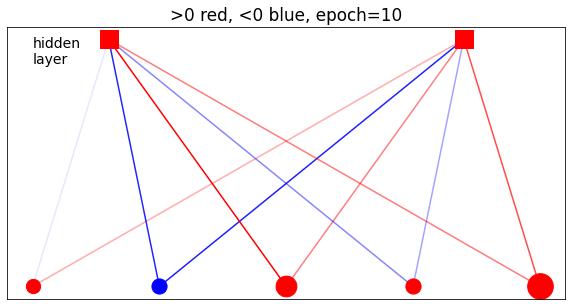

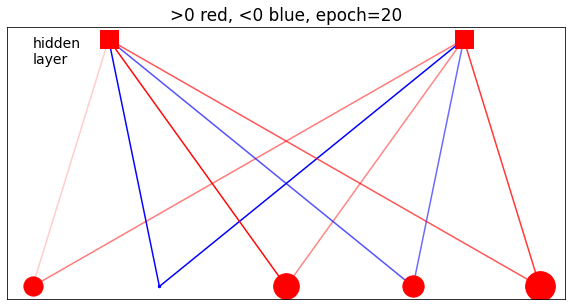

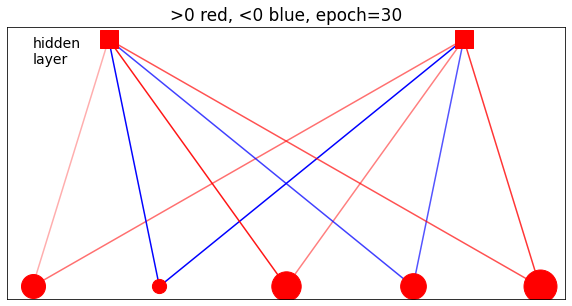

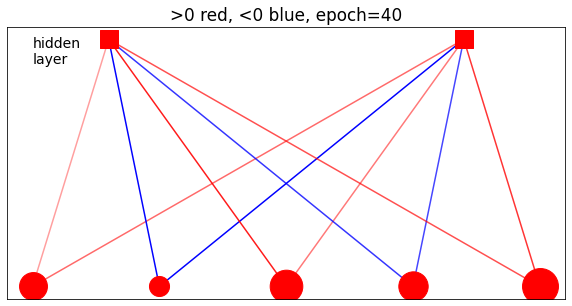

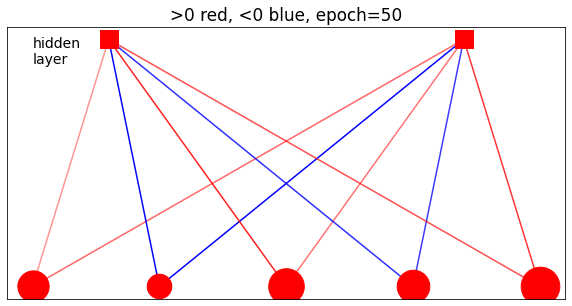

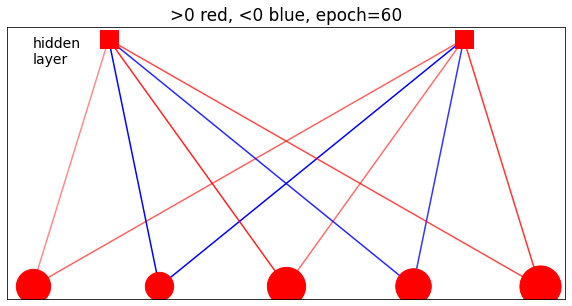

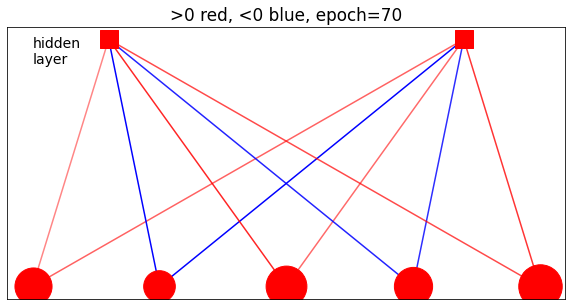

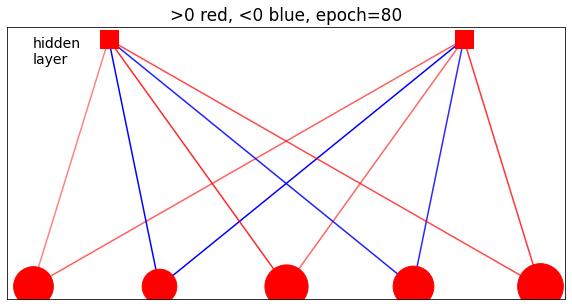

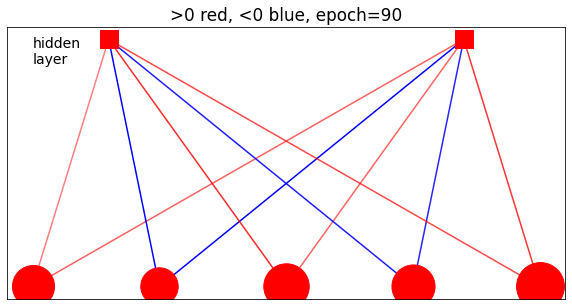

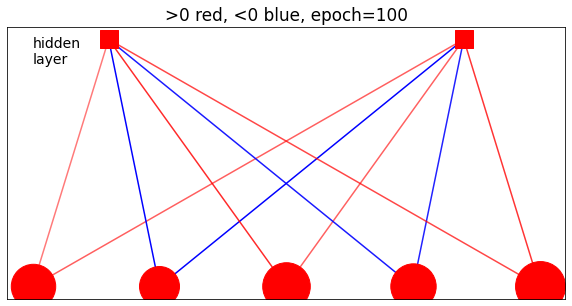

In [5]:
np.random.seed(12345)

# learning rate
l_rate = 1.0

# minibatch
mini, m = 500, 0

beta = 0.9
eps = 10**-8
sw, mw = 0, 0
sa, ma = 0, 0
sb, mb = 0, 0

rms=False
ad=True
div_steps=2

# train model
print('===================================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

        # positive CD phase: generating h 
        h = one_hot_positive(v[k],w,b,GAP)
        # negative CD phase: generating fantasy vf
        vf = one_hot_negative(h,w.T,a,GAP)
        for i in range(div_steps-1):
            hf = one_hot_positive(vf,w,b,GAP)
            vf = one_hot_negative(hf,w.T,a,GAP)
        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = one_hot_positive(vf,w,b,GAP)

        
        h_data  += h
        h_model += hf
        
        uk=[v[k][i*A:(i+1)*A] for i in range(L)]
        um=[vf[i*A:(i+1)*A] for i in range(L)]
        for i in range(L):
            z=uk[i]
            u=0
            for j in range(A):
                u+=z[j]*2**(A-j-1)
            uk[i]=u
            
            z=um[i]
            u=0
            for j in range(A):
                u+=z[j]*2**(A-j-1)
            um[i]=u
        uk=np.array(uk)
        um=np.array(um)
        v_data  += uk
        v_model += um
        vh_data += np.outer(uk.T,h)
        vh_model+= np.outer(um.T,hf)
    
        m += 1
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with rmsprop
            if rms:
                sw, dw = rmsprop(vh_data, vh_model, sw, beta, eps, l_rate_m)
                sa, da = rmsprop(v_data, v_model, sa, beta, eps, l_rate_m)
                sb, db = rmsprop(h_data, h_model, sb, beta, eps, l_rate_m)
            
            if ad:
                mw, sw, dw = adam(vh_data, vh_model, mw, sw, epoch, beta, eps, l_rate_m)
                ma, sa, da = adam(v_data, v_model, ma, sa, epoch, beta, eps, l_rate_m)
                mb, sb, db = adam(h_data, h_model, mb, sb, epoch, beta, eps, l_rate_m)
            
            if epoch<=1 and k<=mini:
                print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                #print('dw =',dw)
                #print('da =',da)
                #print('db =',db)
            # basic step of vanilla gradient descent, from eq.(211)
            w = w + dw
            a = a + da
            b = b + db
            m=0
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    if(rms==True): l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        if not ad:
            print('l_rate = ',l_rate)

In [6]:
from IPython.display import display_html 
import pandas as pd

ampl=8.

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = one_hot_positive(v0[k],w,b,ampl*GAP)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = one_hot_negative(h,w.T,a,ampl*GAP)
# difference between fantasy and data
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(mini)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  


def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
df1s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Denoised').set_table_styles(sty)

display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)

/tmp/ipykernel_8081/139443008.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + exp(-DE*act))
/tmp/ipykernel_8081/139443008.py:9: RuntimeWarning: overflow encountered in exp
  probs = np.cumsum([1. / (1. + exp(-DE*(2**(j+1))*act[i])) for j in range(A)])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
